# Exploratory data analysis of Spotify audio features for Taylor Swift's Discography

## Introduction
People who know me know I have somewhat of a *reputation* of being hopelessly in love with Taylor Swift. That Spotify Wrapped at the end of each year that shows you your most listened to artists? Yeah, mine is *forever and always* tswizzle (that’s her rapper name from *Thug Story* for you non-Swifties). It’s just so hard not to be thoroughly *enchanted* with her, her music, and her cats.

Her discography is not without controversy. When she dropped the reputation album in 2017, her fan base was divided between those who yearned for a return to “Old Taylor” and those who applauded the transition into “New Taylor” (I’m staunchly “Old Taylor,” but I digress).

Fast forward to 2019 with the release of *Lover*, where we got to listen to the most evolutionary (Rolling Stones’ words) album so far. There’s sharper wit, sassier quips, and biting remarks. Not to mention, to date, the most social commentary we’ve heard from an album, which she has traditionally kept non-sociopolitical. Though she has come a long way from her country days, there are always familiar elements to be found: the narrative-style lyrics, falling in love with cities (London Boy) and The Notebook-like rain (*ME!* - “and when we had that fight out in the rain…”).

I recently discovered that Spotify aggregates a lot of interesting data, which got me thinking. How has Taylor’s music changed from her first album to her most recent? Are there any trends unique to her, and is she following directions seen in the broader music industry? And can we use these Spotify-provided metrics to identify these changes?

## Tools
I pulled the data from Spotify’s Web API through [Paul Lamere’s spotipy Python package](https://spotipy.readthedocs.io/en/latest/). Additional analysis is done with the following packages: numpy, pandas, matplotlib, seaborn, and scikit-learn. 

I also used Tableau [to put together a dashboard](https://public.tableau.com/profile/william.li3350#!/vizhome/SpotifygeneratedaudiofeaturesforTaylorSwiftsdiscography/Dashboard1), which I used to write a [blog post](https://liwilli.am/blog/taylor-swift-music-analysis) that closely mirrors the analysis done here.

## Data
[Spotify provides the following metrics](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) for every song in their music library.

**duration_ms**:  	The duration of the track in milliseconds.

**key**:  	The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

**mode**:  	Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

**time_signature**:  	An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

**acousticness**:  	A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

**danceability**:  	Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

**energy**:  	Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

**instrumentalness**:  	Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**liveness**:  	Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**loudness**:  	The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

**speechiness**:  	Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**valence**:  	A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 

**tempo**:  	The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or 
pace of a given piece and derives directly from the average beat duration.

**id**:  	The Spotify ID for the track.

**uri**:  	The Spotify URI for the track.

**track_href**:  	A link to the Web API endpoint providing full details of the track.

**analysis_url**: An HTTP URL to access the full audio analysis of this track. An access token is required to access this data.

**type**:  	The object type: “audio_features”



In [1]:
import spotipy
import csv
import spotipy.util as util
import spotipy.oauth2 as oauth2
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
# Access Spotify API with developer credentials: https://developer.spotify.com/dashboard/

client_id = "CLIENT_ID"
client_secret = "CLIENT_SECRET"

credentials = oauth2.SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
token = credentials.get_access_token()
spotify = spotipy.Spotify(auth=token)

sp = spotipy.Spotify(client_credentials_manager = credentials)

In [3]:
# Pull IDs for album data to include. The ID can be found by going to the Spotify application, 
# right clicking on the album > Share > Copy Spotify URI

album_ids =  [
    "7mzrIsaAjnXihW3InKjlC3", #Taylor Swift
    "2dqn5yOQWdyGwOpOIi9O4x", #Fearless
    "7vzYp7FrKnTRoktBYsx9SF", #Holiday collection
    "5EpMjweRD573ASl7uNiHym", #Speak Now
    "1KlU96Hw9nlvqpBPlSqcTV", #Red
    "34OkZVpuzBa9y40DCy0LPR", #1989
    "6DEjYFkNZh67HP7R9PSZvv", #Reputation
    "1NAmidJlEaVgA3MpcPFYGq", #Lover
]

In [4]:
# Audio features header for csv file to set up Tableau dashboard
audio_features_header = [
  "danceability",
  "energy",
  "key",
  "loudness",
  "mode",
  "speechiness",
  "acousticness",
  "instrumentalness",
  "liveness",
  "valence",
  "tempo",
  "type",
  "id",
  "uri",
  "track_href",
  "analysis_url",
  "duration_ms",
  "time_signature"
]

# Extract data to csv file
file_name = 'taylor swift discography spotify audio features.csv'
csv_file = open(file_name, 'w', newline = '')
csv_writer = csv.writer(csv_file)
other_metadata_header = ['album_id', 'album_name', 'track_id', 'track_name', 'release_date']
csv_writer.writerow(other_metadata_header + audio_features_header)

full_track_list = []
# Extract spotify uri id for every song in album list
for album_id in album_ids:
    for item, track in enumerate(sp.album(album_id)['tracks']['items']):
        full_track_list.append(track['uri'])

# Extract metadata for each track
complete_data = []
for track_id in full_track_list:
    track_data = sp.track(track_id)
    album_id = track_data['album']['id']
    album_name = track_data['album']['name']
    track_id = track_data['id']
    track_name = track_data['name']
    release_date = track_data['album']['release_date']
    other_metadata = [album_id, album_name, track_id, track_name, release_date]

# Extract spotify "audio features" data for each track
# Documentation for audio features description: 
# https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/
    audio_features = []
    # Extract values only from each dictionary pair
    for item in sp.audio_features(track_id):
        for key, value in item.items():
            audio_features.append(value)
    combined_metadata = (other_metadata + audio_features)
    csv_writer.writerow(combined_metadata)
    complete_data.append(combined_metadata)
csv_file.close()

In [5]:
# Convert list to pandas dataframe
#df = pd.DataFrame(complete_data, columns = ['album_id', 'album_name', 'track_id', 'track_name', 'release_date'] + audio_features_header)
df = pd.DataFrame(complete_data, columns = other_metadata_header + audio_features_header)

# Data clean-up!
# Dropping three records that are actually voice memos extras and not actual songs
df = df.drop(df.index[[92,93,94]]).reset_index()

print(df.describe())
print(df.info())

           index  danceability      energy         key    loudness  \
count  125.00000    125.000000  125.000000  125.000000  125.000000   
mean    62.79200      0.609520    0.618096    4.776000   -6.400856   
std     37.25204      0.111403    0.181926    3.207511    2.356598   
min      0.00000      0.292000    0.121000    0.000000  -15.795000   
25%     31.00000      0.544000    0.484000    2.000000   -7.581000   
50%     62.00000      0.608000    0.651000    5.000000   -6.156000   
75%     96.00000      0.687000    0.761000    7.000000   -4.725000   
max    127.00000      0.897000    0.950000   11.000000   -2.030000   

             mode  speechiness  acousticness  instrumentalness    liveness  \
count  125.000000   125.000000    125.000000        125.000000  125.000000   
mean     0.904000     0.055617      0.211332          0.000508    0.145898   
std      0.295777     0.057569      0.258029          0.002729    0.080429   
min      0.000000     0.023900      0.000166          0.0

# Observations
## Track length

In 2014, Taylor Swift penned an [op-ed on the Wall Street Journal](https://www.wsj.com/articles/for-taylor-swift-the-future-of-music-is-a-love-story-1404763219) commenting on the future and worth of music, asserting that “music is art, and art is important and rare. Important, rare things are valuable. Valuable things should be paid for.” The piece explained why she decided to pull her music from the music platform Spotify, who popularized free music streaming. However, she eventually—three years later—gave in to the reality of modern music distribution and put her music back. She predicted that “individual artists… will someday decide what an album’s price point is” did not come true. Five years later, it looks like the pay structure of streaming services ended up dictating those terms. [Artists are observed to write shorter songs now](https://qz.com/1519823/is-spotify-making-songs-shorter/) because streams are paid on a per-play basis, a robust financial incentive that did not historically exist. Fun fact: the modern song and album-length are shaped by the vinyl record’s physical limitations).

I initially suspected that this trend wouldn’t apply to Swift’s songwriting. After all, her album sales for 1989, reputation, and Lover are resoundingly successful outliers among industry declining album sales overall. Plus, her concert tours are some of the highest-grossing tours of all time. But still, the average track length on *Lover* is 3 minutes 26 seconds, a sizable 1 minute 10 seconds or 25% shorter than *Speak Now* at 4 minutes 36 seconds (I'm ignoring the Christmas album and focusing on the studio albums). The economics of shorter songs may have altered consumer attention spans, which has, consciously or subconsciously, influenced Taylor Swift’s songwriting process. We still see a lot of the same verse-chorus-verse-chorus-bridge-chorus format, so it isn’t that her songwriting style has dramatically shifted, but the lengthier, lyrical story-telling now has a smaller presence. For example, there are a lot more songs like *Enchanted* on *Speak Now* than *Cornelia Street* on *Lover*.

                                     duration_sec
album_name                                       
1989 (Deluxe Edition)                       229.0
Fearless                                    247.0
Lover                                       206.0
Red (Deluxe Edition)                        246.0
Speak Now (Deluxe Edition)                  276.0
Taylor Swift                                214.0
The Taylor Swift Holiday Collection         191.0
reputation                                  223.0
The difference in seconds between the longest and shortest studio albums average track length is  70.0  seconds
On average, tracks on Lover are  25.36 % shorter than tracks on Speak Now


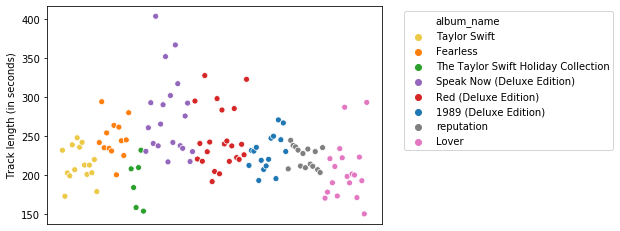

In [6]:
# Add track length in seconds from milliseconds for easier readability
df['duration_sec'] = df['duration_ms'] / 1000

# Creating subset of dataframe to look at track length
df_track_length = df[['album_name', 'track_name', 'duration_sec']]
df_track_length_by_album = df_track_length.groupby(['album_name']).apply(np.mean).round(0)
print(df_track_length_by_album)

lover = df_track_length_by_album.loc['Lover'].values[0]
speaknow = df_track_length_by_album.loc['Speak Now (Deluxe Edition)'].values[0]
difference = speaknow - lover
print("The difference in seconds between the longest and shortest studio albums average track length is ", difference.round(0),  " seconds")
print("On average, tracks on Lover are ", abs((lover/speaknow)-1).round(4)*100,"% shorter than tracks on Speak Now")

# Create scatter plot and stylize graph
# Colors to match the palette I'm using in Tableau for consistency
palette = {"Taylor Swift":"#EDC948", "Fearless":"tab:orange", "The Taylor Swift Holiday Collection":"tab:green", "Speak Now (Deluxe Edition)":"tab:purple", "Red (Deluxe Edition)":"tab:red", "1989 (Deluxe Edition)":"tab:blue", "reputation":"tab:gray", "Lover":"tab:pink"}
sns.scatterplot(x = 'track_name', y = 'duration_sec', data = df_track_length, hue = 'album_name', palette = palette)
plt.ylabel('Track length (in seconds)')
plt.xlabel('')
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

### Vocal Range
**Warning: This next part gets a little music theory intensive. Sorry!**

Taylor Swift’s vocals have definitely matured over the years; she even lost her country twang! As far as pop artists go, she doesn’t boast a very wide vocal range. She briefly hits A2 on Cruel Summer (“I'm always waiting for you to be waiting below”), and she harmonizes a G5 on Bad Blood (“It’s so sad to"). But in her live performances, she seems to sound most comfortable in a slightly narrower range, around C3 to C5. So it actually comes as no surprise then that a lot of her songs (33 tracks) are written in, you guessed it, C (and D). And because C and D share many common chords with F, G, and A, we would expect her to be comfortable writing melodies over those keys as well (53 tracks). Together, these five (out of twelve possible) keys cover 86 out of 125 (69%) tracks in our analysis. It seems like she has a preference for keys with sharps over flats, and definitely for ones with fewer sharps and flats, which almost sounds like a byproduct of her guitar upbringing. Maybe she was content with strumming simple, open chords. It is not uncommon to use a capo to transpose instead of learning chord fingerings up the neck (I am so guilty of this.)

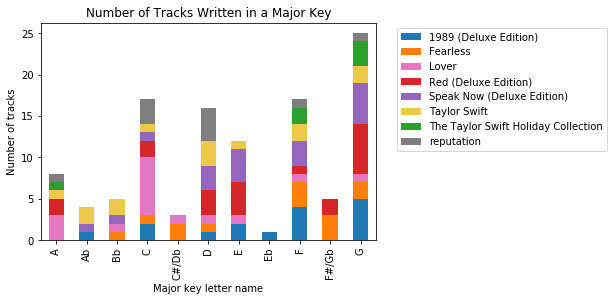

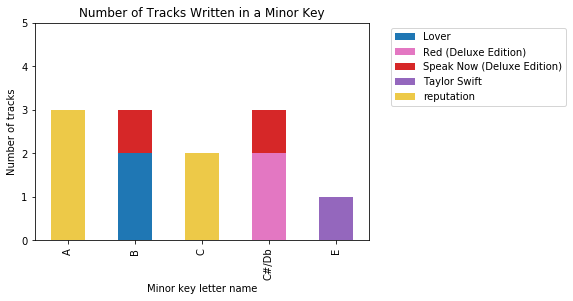

In [7]:
# Map Spotify codes to musical notation
key_dict = {0:"C", 1:"C#/Db", 2:"D", 3:"Eb" , 4:"E" , 5:"F" , 6:"F#/Gb" , 7:"G" , 8:"Ab" , 9:"A" , 10:"Bb" , 11:"B"}
df['new_key'] = df['key'].map(key_dict)

# Creating subset of dataframe to look at just musical key and mode
df_key_mode = df[['album_name', 'track_name', 'new_key', 'mode']]
df_key_mode_major = df_key_mode[df_key_mode['mode'] == 1]
df_key_mode_minor = df_key_mode[df_key_mode['mode'] == 0]

# Looking at mode = 1 major keys only
df_key_mode_by_album_major = df_key_mode_major.pivot_table(index = 'new_key', columns = 'album_name', values = 'track_name', aggfunc = 'count').fillna(value = 0)
# Looking at mode = 0 minor keys only
df_key_mode_by_album_minor = df_key_mode_minor.pivot_table(index = 'new_key', columns = 'album_name', values = 'track_name', aggfunc = 'count').fillna(value = 0)

# Create stacked bar chart and stylize graphs
df_key_mode_by_album_major.plot(kind='bar', stacked=True, color = ["tab:blue", "tab:orange", "tab:pink", "tab:red", "tab:purple", "#EDC948", "tab:green", "tab:gray"])
plt.ylabel('Number of tracks')
plt.xlabel('Major key letter name')
plt.title('Number of Tracks Written in a Major Key')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

df_key_mode_by_album_minor.plot(kind='bar', stacked=True, color = ["tab:blue", "tab:pink", "tab:red", "tab:purple", "#EDC948", "tab:gray"])
plt.ylabel('Number of tracks')
plt.xlabel('Minor key letter name')
plt.title('Number of Tracks Written in a Minor Key')
plt.yticks(np.arange(0, 6, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

## Lyricism and singing style
As the 2000s came to an end, pop music saw less of an appreciation for artists belting out intricate but over-the-top melismatic runs in powerhouse ballads. Enter Taylor Swift, riding a wave of popularity that capitalized on her narrative-based lyricism and story-telling accompanied by clean, unadorned vocals. And part of story-telling is dialogue, which Taylor has incorporated more and more over her career in snippets of spoken word. See: backing vocals on *Better Than Revenge*, the bridge on *We Are Never Ever Getting Back Together* and *Shake it Off*, the titular lyric in *…Ready For It?*, and most recently, the seamless transition to a deadpan “indifference” in *I Forgot That You Existed.*

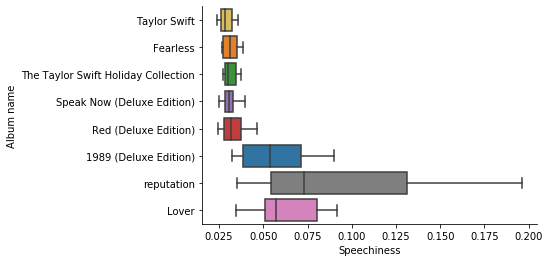

In [8]:
# Creating subset of dataframe to look at speechiness only
df_speechiness = df[['album_name', 'track_name', 'speechiness']]

# Create boxplot and stylize graph, removed severe outliers
sns.boxplot(y='album_name', x='speechiness', data = df_speechiness, showfliers=False, palette = palette)
plt.xlabel('Speechiness')
plt.ylabel('Album name')
sns.despine()

Taylor Swift is well-known for her dating life, which she has leaned on for inspiration in her “break-up” songs. Most of her music hovers lower on the valence metric (62% are below a rating of 0.5), though she does curate a delicate balance between the sadder songs and the more upbeat, happy songs. The outlier in this metric is the reputation album, where 14 out of 15 tracks are below a rating of 0.5. This discrepancy affirms that the darker-sounding album was written during a time that Taylor identified as a low-point in her life. Incidentally, this is the album where she had the most instances of songs written in a minor key, which Western music has traditionally regarded as sad-sounding. However, there doesn’t seem to be a statistical difference in the valence metric between songs grouped by major keys and songs grouped by minor keys (the minor key group has a very small sample size though).

There are 77 tracks below a valence score of 0.5. Of these, 14 are on the reputation album.


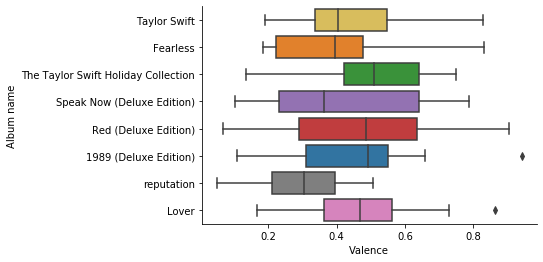

In [9]:
# Creating subset of dataframe to look at valence
df_valence = df[['album_name', 'track_name', 'valence', 'mode']]
df_valence_major = df_valence[df_valence['mode'] == 1]
df_valence_minor = df_valence[df_valence['mode'] == 0]

# Create boxplot and stylize graph, removed severe outliers
sns.boxplot(y='album_name', x='valence', data = df_valence, palette = palette)
plt.xlabel('Valence')
plt.ylabel('Album name')
sns.despine()

tracks_low_valence = df_valence[df_valence['valence'] < 0.5]
tracks_low_valence_reputation = tracks_low_valence[tracks_low_valence['album_name'] == 'reputation']
print('There are', len(tracks_low_valence), 'tracks below a valence score of 0.5. Of these,', len(tracks_low_valence_reputation), 'are on the reputation album.')

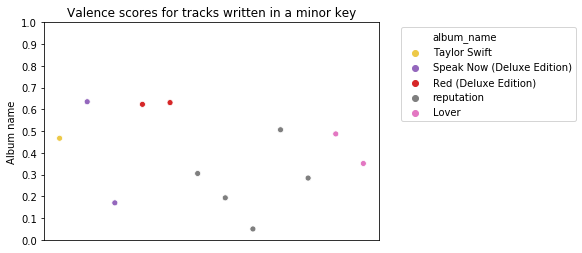

In [10]:
sns.scatterplot(x='track_name', y='valence', hue = 'album_name', data = df_valence_minor, palette = palette)
plt.xlabel('')
plt.ylabel('Album name')
plt.yticks(np.arange(0,1.1,.1))
plt.title('Valence scores for tracks written in a minor key')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.tick_params(axis = 'x', which = 'both', bottom = False, top = False, labelbottom = False)

## Instrumentation

Her most recent album, Lover, is the most acoustically diverse album so far, which is a surprise for two reasons. First, the album follows reputation, which utilized its fair share of hip hop and trap music-inspired beats. Secondly, as the 2010s come to a close, EDM sounds, which are generally electronically synthesized, have found their way into pop music. Perhaps Lover’s return to more guitar and piano instrumentation is a sign of Swift’s maturity and contentedness with not having to reinvent herself with each new album. In retrospect, it seems like New Year’s Day, the final track on reputation, was already signaling a return towards those roots.

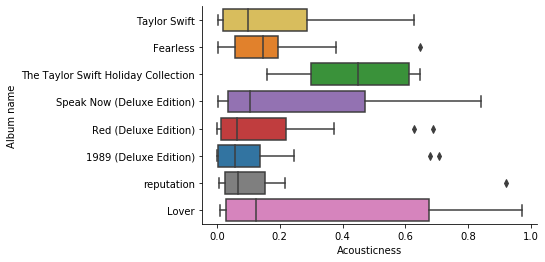

In [11]:
# Creating subset of dataframe to look at acousticness
df_acousticness = df[['album_name', 'track_name', 'acousticness']]

sns.boxplot(y='album_name', x='acousticness', data = df_acousticness, palette = palette)
plt.xlabel('Acousticness')
plt.ylabel('Album name')
sns.despine()

## Old Taylor versus New Taylor 

Her fanbase was sharply divided when she dropped the single *Look What You Made Me Do* with the lyrics self-proclaiming: "I'm sorry, the old Taylor can't come to the phone right now. Why? Oh, 'cause she's dead!" Can we categorically classify between Old Taylor and New Taylor based off of the metrics we've looked at so far?

### K-Nearest Neighbors Analysis

The most commonly accepted definition of "Old Taylor" is all her music pre-reputation album. As a binary before/after scenario, we can tackle the question using KNN classification. Now, we're a little sparse on "New Taylor" data, with just two albums to the six that preceded, so to train the model evenly, I'm picking the two most popular "Old Taylor" albums using Spotify's "popularity" metric for albums to be representative of her discography during that era. Looks like "Fearless" and "Red" are the most listened to! (as of 11/4/2019).

Quick aside: Great [scikit-learn flowchart](https://scikit-learn.org/stable/tutorial/machine_learning_map/) to help understand what estimators to use in machine learning.


In [12]:
popularity = {}
for album_id in album_ids:
    popularity[sp.album(album_id)['name']] = sp.album(album_id)['popularity']
    
print(popularity)

{'Taylor Swift': 64, 'Fearless': 67, 'The Taylor Swift Holiday Collection': 45, 'Speak Now (Deluxe Edition)': 65, 'Red (Deluxe Edition)': 68, '1989 (Deluxe Edition)': 65, 'reputation': 77, 'Lover': 93}


In [13]:
# Labeling albums "Old Taylor" vs "New Taylor"
df['old_or_new_taylor'] = np.where((df['album_name'] == 'reputation') | (df['album_name'] == 'Lover'), 'New Taylor', 'Old Taylor')

# Creating arrays for the features and response variable
# Keeping the two "Old Taylor" albums, Fearless and Red, and the two "New Taylor" albums, reputation and Lover
X = df.loc[((df['album_name'] == 'Fearless') | (df['album_name'] == 'Red (Deluxe Edition)')) | (df['old_or_new_taylor'] == 'New Taylor'),:]

# Dropping extraneous metadata columns
y = X['old_or_new_taylor']
X = X.drop(['index', 'album_id', 'album_name', 'track_id', 'track_name', 'release_date', 'loudness', 'instrumentalness', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature', 'new_key', 'duration_sec', 'old_or_new_taylor'], axis = 1)

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, metrics
from sklearn.feature_selection import RFE

# Normalizing the features
scaler = preprocessing.MinMaxScaler()
scaler.fit(X)
rescaledX = scaler.transform(X)

# Initialize knn classifier
knn = KNeighborsClassifier(n_neighbors = 5)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(rescaledX, y, test_size = 0.50, random_state = 1, stratify = y)

# Fit data
knn.fit(X_train, y_train)

# Print accuracy
print('Accuracy:', knn.score(X_test, y_test).round(4))

# Tune parameters
params = {'n_neighbors':[3,5,7,9,11,13,15], 'weights': ['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}
gs = GridSearchCV(knn, params, cv=10, iid = False)
gs.fit(rescaledX,y)
gs.best_params_

knn = KNeighborsClassifier(n_neighbors = 7, metric = 'manhattan', weights = 'distance')
X_train, X_test, y_train, y_test = train_test_split(rescaledX, y, test_size = 0.50, random_state = 1, stratify = y)
knn.fit(X_train, y_train)
print(gs.best_params_)
print('Accuracy with parameters tuned using cross-validation:', knn.score(X_test, y_test).round(4))

Accuracy: 0.6176
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy with parameters tuned using cross-validation: 0.6471


We achieve 62% accuracy using n = 5 for k-nearest neighbors, which is marginally better than guessing (50%). However, even tuning the parameters (to use distance weighting instead of uniform, and Manhattan distance instead of Euclidean) achieves mild improvement (+6%). 

One explanation for the low accuracy is that we are passing through a lot of features that are fairly consistent between the two labels. When we limit the features to the ones we looked at in the above exploratory data analysis (I'm taking out key and mode too, which are technically categorical data that are actually ill-represented the way we've currently normalized them), our accuracy goes up to 82% (+20%), which is a lot better, but still less than ideal. Another explanation is that Spotify doesn't have the right audio data to classify the sonic differences between the two eras of Taylor Swift.


In [15]:
X_new = X[['duration_ms', 'speechiness', 'valence', 'acousticness']]
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_new)
rescaledX_new = scaler.transform(X_new)
knn = KNeighborsClassifier(n_neighbors = 9, metric = 'manhattan', weights = 'distance')
X_train, X_test, y_train, y_test = train_test_split(rescaledX_new, y, test_size = 0.50, random_state = 1, stratify = y)
knn.fit(X_train, y_train)
print('Accuracy using tuned parameters and fewer features:', knn.score(X_test, y_test).round(4))

params = {'n_neighbors':[3,5,7,9,11,13,15], 'weights': ['uniform', 'distance'], 'metric':['euclidean', 'manhattan']}
gs = GridSearchCV(knn, params, cv=5, iid = False)
gs.fit(X_train,y_train)
gs.best_params_

Accuracy using tuned parameters and fewer features: 0.8235


{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}

## K-Means Clustering

What if instead of labeling the results ourselves and having the model figure out what's Old and New Taylor, we let the data figure out for itself how it should be grouped?

In [16]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

df_kmeans = df.drop(['index', 'album_id', 'album_name', 'track_id', 'track_name', 'release_date', 'loudness', 'instrumentalness', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature', 'new_key', 'duration_sec', 'old_or_new_taylor'], axis = 1)

# Initialize KMeans model with 2 clusters
kmeans = KMeans(n_clusters = 2)

# Normalize data
scaler = preprocessing.MinMaxScaler()

# Create pipeline
pipeline = make_pipeline(scaler, kmeans)
pipeline.fit(df_kmeans)
labels = pipeline.predict(df_kmeans)
df_compare = pd.DataFrame({'track name':df['track_name'], 'prediction':labels})
print(df_compare.sort_values('prediction'))

                                  track name  prediction
55                                       Red           0
102              Dancing With Our Hands Tied           0
43                       Better Than Revenge           0
94                       I Did Something Bad           0
119                                False God           0
95                            Don’t Blame Me           0
96                                  Delicate           0
97                  Look What You Made Me Do           0
8                          Should've Said No           0
44                                  Innocent           0
113   Miss Americana & The Heartbreak Prince           0
74             Red - Original Demo Recording           0
82                          I Wish You Would           1
0                                 Tim McGraw           1
84                            Wildest Dreams           1
85                      How You Get The Girl           1
86                             

The results of the two cluster model resulted in a cluster with those first twelve tracks. *I Did Something Bad*, *Don't Blame Me*, *Delicate*, *Look What You Made Me Do*, and *Dancing With Our Hands Tied* are all off the reputation album, and *Miss Americana & The Heartbreak Prince* and *False God* are off Lover. At random, we'd expect about 25% of the tracks to be "New Taylor," but instead we got 58%, so the model is definitely on the right track!

## Conclusion
We looked at the supervised learning method k-nearest neighbors and the unsupervised learning method k-means clustering. Through data provided by Spotify's public API, we attempted to identify a marked shift in Taylor Swift's musical career through the provided audio features. Though the analyses were rudimentary, they signal that the data is unable to predict with a high degree of confidence the answers we were expecting. The audio features may be sufficient for broader questions, such as identifying genre-defining features--rap, for example, would score very high on speechiness compared to pop music. However, to draw the line between Old Taylor and New Taylor, these models may have more success with musical melody and lyric data instead.

I'm starting to understand how Spotify might go about recommending new playlists or songs based on our listening activity. For example, in my own listening activity, the five "Daily Mix" playlists are split by genre and are probably generated by clustering the songs I listen into five groups and extrapolated to identify songs that are most similar.

There are metrics I didn’t go into that you can take a look at in the Tableau dashboard I linked to in the tools section. 

Next time: Sentiment analysis on lyrics and attempting to group from there?